# Two layer perceptron 3.2

In [476]:
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split

## Generating data

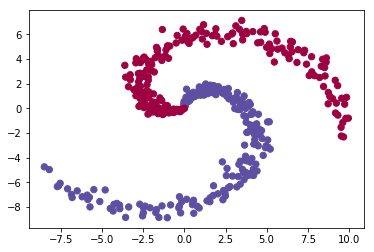

In [477]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 2 # number of classes
X = np.zeros((N*K,D))# data matrix (each row = single example)
#y = np.zeros(N*K, dtype='uint8') # class labels

y = np.ones(N,dtype=np.int)
minus = -1 * np.ones(N,dtype=np.int)
y = np.append(y,minus)

for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,10,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    #y[ix] = j
    
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)


'''
train = X[:int(len(X)/2)]
test = X[int(len(X)/2):]
train_class = y[:int(len(X)/2)]
test_class = y[int(len(X)/2):]
'''

# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [478]:
len(y_test)

100

## General code for two layer perceptron

In [479]:
class neuralNet():
    def __init__(self,dim,nr1,nr2):
        self.nrOfInputs = dim
        self.trainAbsErrors = [] #Storing error in each epoch to plot learning curve
        self.trainMseErrors = []
        self.testAbsErrors = []
        self.testMseErrors = []
        
        self.shape_y = 0
        
        self.finalW = [] #Store weights when training is done
        
        self.nrOfNodes_layer1 = nr1
        self.nrOfNodes_layer2 = nr2
    
    def initWeights(self,nrOfNeuronsInLayer,nrOfInputsPerNeuron):
        #Need to add one one weight for bias term
        w = np.random.normal(0,1,size=(nrOfInputsPerNeuron+1,nrOfNeuronsInLayer))
        return w
    
    #Introduces non-linearity
    def transferFunc(self,x):
        transformed = 2/(1+np.exp(-x))-1
        return transformed

    def transferDerivative(self, x):
        derivative = np.multiply((1+x),(1-x))/2
        return derivative
    
    def predict(self,patterns):
        pass
        
    def forwardPass(self,patterns,w_1,w_2,bias):
        patterns = np.column_stack([patterns,bias])
        
        h_in = np.dot(patterns,w_1) #hin = w_1*[patterns + bias] (transposed)            
        h_out = np.column_stack([self.transferFunc(h_in),bias]) #hout = [transferFunc(hin)+bias]    
        o_in = np.dot(h_out,w_2) #oin = w_2 * hout (transposed)
        o_out = self.transferFunc(o_in) #out = transferFunc(oin)
        
        return h_out,o_out
    
    def backPropagation(self,targets,h_out,o_out,w_2):
        targets = targets.reshape(len(targets),self.shape_y)        
        delta_o = np.multiply((o_out-targets),self.transferDerivative(o_out))    
        delta_h = np.dot(delta_o,w_2.T)*self.transferDerivative(h_out)
        delta_h = delta_h[:,:self.nrOfNodes_layer1]
        return delta_h,delta_o
        
    def calcError(self,predictions,y,epochNr,traintest):
        #Implementera mean square error 
        absError = 0
        squared_e = 0
        for i in range(len(y)):
            if(self.shape_y==1):
                pred=predictions[i]
            else:
                pred=predictions[i][0]
            squared_e+=math.pow((pred-y[i]),2)
            if pred>0:
                threshold_pred=1
            else:
                threshold_pred=-1

            #If prediction is false, increment error
            if(threshold_pred!=y[i]):
                    absError+=1
        
        absErrorRatio=absError/len(y)
        mse = squared_e/len(y)            
        #print("Nr of errors in",traintest,"data during epoch",epochNr,":",absError)
        
        return [absErrorRatio,mse]
    
    def train_batch(self,X,y,X_test,y_test,epochs):
        self.shape_y = int(y.size/len(y))
        w_1 = self.initWeights(self.nrOfNodes_layer1,self.nrOfInputs) #Weights for first layer
        w_2 = self.initWeights(self.nrOfNodes_layer2,self.nrOfNodes_layer1) #Weights for second layer
        dw_1 = 0
        dw_2 = 0
        
        bias = np.ones(len(X),dtype=int)
        
        for epoch in range(epochs):
            
            #Forward pass
            h_out,o_out = self.forwardPass(X,w_1,w_2,bias)

            #backPropagation
            delta_h,delta_o = self.backPropagation(y,h_out,o_out,w_2)
            
            #updateWeights
            alpha=0.9
            eta=0.001
            
            #dw_1 = np.multiply(dw_1,alpha)-np.dot(X.T,delta_h)*(1-alpha)
            dw_1 = np.multiply(dw_1,alpha)-np.dot(np.column_stack([X,bias]).T,delta_h)*(1-alpha)
            dw_2 = np.multiply(dw_2,alpha)-np.dot(h_out.T,delta_o)*(1-alpha)
            
            w_1 = w_1 + dw_1*eta
            w_2 = w_2 + dw_2*eta
            

            #Make a prediction on training data with the current weights
            _,predictions_train = self.forwardPass(X,w_1,w_2,bias)

            train_abs, train_mse = self.calcError(predictions_train,y,epoch,"train")
            self.trainAbsErrors.append(train_abs)
            self.trainMseErrors.append(train_mse)

            #Make a prediction on testing data with the current weights
            test_bias = np.ones(len(X_test),dtype=int) #Need other dimensions
            _,predictions_test = self.forwardPass(X_test,w_1,w_2,test_bias) #calc error on testdata as well

            test_abs, test_mse = self.calcError(predictions_test,y_test,epoch,"test")
            self.testAbsErrors.append(test_abs)
            self.testMseErrors.append(test_mse)
        
        self.finalW = [w_1,w_2]
        #self.plotDecBoundary(X_test,y_test,w_1,w_2,test_bias)
            
        
    
    def evaluate(self,epochs):
        f,axarr = plt.subplots(2,sharex=True)
        axarr[0].plot(range(epochs),self.trainAbsErrors, 'o')
        axarr[0].plot(range(epochs),self.testAbsErrors, 'x')
        axarr[0].set_title('Ratio of misclassifications o=train, x=test')
        
        axarr[1].plot(range(epochs),self.trainMseErrors, 'o')
        axarr[1].plot(range(epochs),self.testMseErrors, 'x')
        axarr[1].set_title('Mean squared error')
        
        plt.grid()
        plt.show()
        
        
    def printErrors(self):
        print("Final misclassification ratio:",self.testAbsErrors[len(self.testAbsErrors)-1])
        print("Final MSE:",self.testMseErrors[len(self.testMseErrors)-1])        

## Experiments for 3.2.1

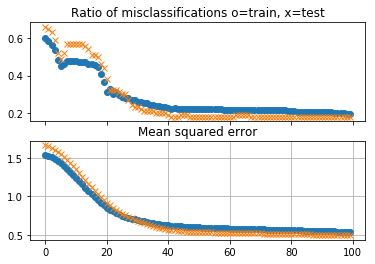

Final misclassification ratio: 0.18
Final MSE: 0.49267239500905463


In [480]:
nodesInFirstLayer=4
nodesInSecondLayer=1
nrOfInputs=2
epochs = 100

nn = neuralNet(nrOfInputs,nodesInFirstLayer,nodesInSecondLayer) 
nn.train_batch(X_train,y_train,X_test,y_test,epochs)
nn.evaluate(epochs)
nn.printErrors()

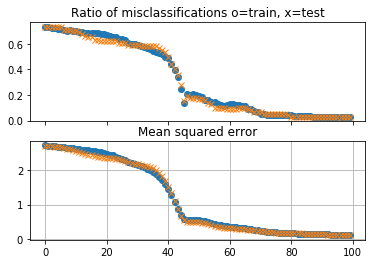

Final misclassification ratio: 0.03
Final MSE: 0.10376990664690368


In [481]:
nodesInFirstLayer=32
nodesInSecondLayer=1
epochs = 100
nrOfInputs=2

nn = neuralNet(nrOfInputs,nodesInFirstLayer,nodesInSecondLayer) 
nn.train_batch(X_train,y_train,X_test,y_test,epochs)
nn.evaluate(epochs)
nn.printErrors()

## Experiments for 3.2.2
The encoding problem. Set up network with 8-3-8 structure

In [482]:
def generateAutoData(nr):
    X_auto = []
    for i in range(nr):
        index = np.random.randint(8)-1
        one8 = -1*np.ones(8, dtype=int)
        one8[index]=1
        X_auto.append(one8)
    return np.array(X_auto)
        
    
X_auto = generateAutoData(200)

In [483]:
nrOfInputs = 8
nodesInFirstLayer=3
nodesInSecondLayer=8

epochs = 100

nn = neuralNet(nrOfInputs,nodesInFirstLayer,nodesInSecondLayer) 
nn.train_batch(X_auto,X_auto,X_auto,X_auto,20)
print("hej")

TypeError: only length-1 arrays can be converted to Python scalars